# Extension of Exploratory Data Analysis

In this section, we explore polarity and subjectivity of customer reviews dataset, lenght of reviews and look for patterns to find useful similarities and differences between the reviews to build features vectors in the next Machine Learning sections. Customer reviews will be used to predict the satisfaction and to investigate the causes of those good or bad experiences, defined as categories. We'll be able to split coffee shops in clusters according to how much positive or negative are the mentions that people do in every category. Additionally, the blog reviews are used exclusively to build clusters of coffee shops related to features extracted from the descriptions.

## Guideline

The main purposes here are the following:
### To Resolve the Predictive Score Modeling:
- Compare different polarity algorithms to determine which is the most appropiate in this scenario.
- Determine if we must calculate polarity scores per review or sentences into the reviews and then take the average or some percentile to estimate the polarity of the review.
- Determine if is useful to use more than one polarity algorithm as feature.
- Look for more potential language features (as lenght of the message, distribution of the polarity and subjectivity into the review, type of language, slangs, uppercase expressions, etc).


### To Resolve topics that people mention in their reviews:
- Create dictionary of words per topic.
- Use Topic Modeling Hierarchical
- Use TF-IDF and select some key-words
- Use word embeddings

### To Resolve the unsupervised clustering of coffee shops:
- Use information from blogs and brief descriptions.
- Identify features (as presence or absence of wifi, music, decoration, tables and others)

# 1. Features for predictive score modeling

Importing relevant packages

In [1]:
import warnings

warnings.filterwarnings("ignore")

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import re

### a. TextBlob

Defining the **sentiment parameters pattern** function using one of the sentiment analyzer provides for *TextBlob*

In [2]:
from textblob.sentiments import PatternAnalyzer
from textblob import TextBlob

def sentiment_parameters_textblob(text_data):
    blob = TextBlob(text_data, analyzer=PatternAnalyzer())
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In this case, we get a **polarity** and a **subjectivity score**.

### b. nltk Sentiment Intensity Analyzer

In [3]:
import nltk

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_nltk = SentimentIntensityAnalyzer()

def sentiment_parameters_nltk(text_data):
    return sentiment_nltk.polarity_scores(text_data)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daniela/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### c. FLAIR Sentiment Classifier

In [4]:
import sys
#!{sys.executable} -m pip install flair
import flair

flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

def sentiment_parameters_flair(text_data):
    s = flair.data.Sentence(text_data)
    flair_sentiment.predict(s)
    return s.labels

2020-06-16 13:49:23,991 loading file /Users/daniela/.flair/models/sentiment-en-mix-distillbert.pt


### Customer reviews dataset

In [5]:
df_reviews = pd.read_csv("../Data_Extraction/Reviews/reviews_rating_date.csv", \
                         usecols=['Coffee', 'Description','Rating', 'date'])

In [6]:
df_reviews.tail()

,Coffee,Description,Rating,date
3543,Red Door,Great atmosphere. Awesome coffee. One of my fa...,4.0 star rating,2/26/2018
3544,Red Door,This place was great- recommended to me by som...,4.0 star rating,2/5/2018
3545,Red Door,I really like the concept of this place - coff...,3.0 star rating,12/15/2017
3546,Red Door,"I love the artsy vibes in this cafe, because i...",4.0 star rating,10/29/2017
3547,Red Door,Really nice coffee shop within an art gallery....,5.0 star rating,10/17/2017


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 4 columns):
Coffee         3268 non-null object
Description    3548 non-null object
Rating         3548 non-null object
date           3548 non-null object
dtypes: object(4)
memory usage: 111.0+ KB


### Pre-processing steps

In [8]:
df_reviews['scores'] = df_reviews['Rating'].str.split(' star rating').str.get(0).astype(float)

In [9]:
df_reviews.drop(columns='Rating', inplace=True)

In [10]:
import datetime

def validate_date(date_str):
    try:
        date_updated = datetime.datetime.strptime(date_str.splitlines()[0], "%m/%d/%Y")
    except:
        print(date_str)
        raise ValueError("Incorrect data format, should be MM-DD-YYYY")
    return date_updated

In [11]:
df_reviews['valid_date'] =  df_reviews.date.apply(validate_date)

In [12]:
df_reviews.drop(columns='date', inplace=True)

In [13]:
df_reviews.Coffee[20:40] = 'Coffee 1'
df_reviews.Coffee[40:60] = 'Coffee 2'
df_reviews.Coffee[60:80] = 'The Mill'
df_reviews.Coffee[1939:1959] = 'The Mill 1'
df_reviews.Coffee[1200:1220] = 'Andytown Coffee 1'
df_reviews.Coffee[1691:1711] = 'Réveille Coffee 1'
df_reviews.Coffee[340:360] = 'Sightglass 1'
df_reviews.Coffee[780:800] = 'Sightglass 2'
df_reviews.Coffee[2439:2459] = 'Sightglass 3'
df_reviews.Coffee[940:960] = 'Saint Frank 2'
df_reviews.Coffee[800:820] = 'Philz 1'
df_reviews.Coffee[2739:2759] = 'Philz 2'
df_reviews.Coffee[3228:3248] = 'Philz 3'
df_reviews.Coffee[700:720] = 'Blue Bottle 1'
df_reviews.Coffee[2119:2139] = 'Blue Bottle 2'
df_reviews.Coffee[2499:2519] = 'Blue Bottle 3'
df_reviews.Coffee[2299:2319] = 'Jane on 1'
df_reviews.Coffee[2159:2179] = 'Equator Coffees & 1'
df_reviews.Coffee[2399:2419] = 'Equator Coffees & 2'
df_reviews.Coffee[3172:3192] = 'Contraband Coffee 1'
df_reviews.Coffee[2859:2879] = 'Little 1'
df_reviews.Coffee[1471:1491] = 'Cafe 1'
df_reviews.Coffee[2599:2619] = 'Cafe 2'
df_reviews.Coffee[2962:2982] = 'Cafe 3'
df_reviews.Coffee[3122:3132] = 'Bluestone 1'
df_reviews.Coffee[3528:3548] = 'Red Door 1'
df_reviews.Coffee[2339:2359] = 'Martha & Brothers 1'
df_reviews.Coffee[3042:3062] = 'Boba 1'
df_reviews.Coffee[3102:3122] = 'Boba 2'

In [98]:
df_reviews.dropna(subset=['Coffee'], inplace=True)

In [99]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308 entries, 0 to 3547
Data columns (total 22 columns):
Coffee                    3308 non-null object
Description               3308 non-null object
scores                    3308 non-null float64
valid_date                3308 non-null datetime64[ns]
polarity_textblob         3308 non-null float64
subjectivity_textblob     3308 non-null float64
neg_nltk                  3308 non-null float64
neu_nltk                  3308 non-null float64
pos_nltk                  3308 non-null float64
compound_nltk             3308 non-null float64
value_flair               3308 non-null object
score_flair               3308 non-null float64
flesch                    3308 non-null float64
smog_index                3308 non-null float64
kincaid_grade             3308 non-null float64
coleman_liau_index        3308 non-null float64
ari                       3308 non-null float64
dale_chall_readability    3308 non-null float64
difficult_words          

### 1.1 Sentiment Analysis: Polarity and Subjectivity Patterns using TextBlob, NLTK and Flair:

In [14]:
df_reviews['polarity_textblob'] = [sentiment_parameters_textblob(r)[0] for r in df_reviews['Description']]

In [15]:
df_reviews['subjectivity_textblob'] = [sentiment_parameters_textblob(r)[1] for r in df_reviews['Description']]

In [16]:
df_reviews['neg_nltk'] = [sentiment_parameters_nltk(r)['neg'] for r in df_reviews['Description']]

In [17]:
df_reviews['neu_nltk'] = [sentiment_parameters_nltk(r)['neu'] for r in df_reviews['Description']]

In [18]:
df_reviews['pos_nltk'] = [sentiment_parameters_nltk(r)['pos'] for r in df_reviews['Description']]

In [19]:
df_reviews['compound_nltk'] = [sentiment_parameters_nltk(r)['compound'] for r in df_reviews['Description']]

In [20]:
df_reviews['value_flair'] = [sentiment_parameters_flair(r)[0].value for r in df_reviews['Description']]

In [21]:
df_reviews['score_flair'] = [sentiment_parameters_flair(r)[0].score for r in df_reviews['Description']]

In [22]:
df_reviews.head()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,score_flair
0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",4.0,2019-05-10,0.250758,0.692424,0.102,0.661,0.237,0.9308,POSITIVE,0.998546
1,Réveille Coffee,"I wanted to like this place, however the venti...",2.0,2019-04-20,0.051736,0.624306,0.075,0.826,0.099,0.1606,NEGATIVE,0.999996
2,Réveille Coffee,I didn't tried brunch before in another locati...,5.0,2019-04-18,0.666667,0.616667,0.000,0.655,0.345,0.9538,POSITIVE,0.997934
3,Réveille Coffee,"Folks, avoid this place unless you like being ...",1.0,2019-04-16,0.070000,0.607778,0.075,0.822,0.103,0.6261,NEGATIVE,0.999989
4,Réveille Coffee,A nice compact coffee shop at Castro area. Qua...,4.0,2019-04-16,0.390000,0.610000,0.000,0.647,0.353,0.8689,POSITIVE,0.968480


### 1.2 Readability tests applied to reviews

In this section, we use **textstat**, a Python package to calculate statistics from text to determine readability, complexity and grade level of a particular corpus. The scores gives us information about how easy or difficult to understand are the reviews.

1. Flesch Reading Ease — The general idea with Flesch Reading Ease is that the avg. length of the sentences and the avg. number of syllables per word to calculate the reading ease.
The median score for readable text is 60–70

Where do we use Flesch Reading Ease? Unproven but it’s a good factor to consider for SEO. Usually, for holistic SEO, readability is key. [3]
If your text is very complicated, you may scare off your audience and make them search elsewhere for information.

2. Gunning Fog — Gunning Fog unlike Flesch Reading Ease, does not output a numeric score. Instead, Gunning Fog estimates an index — the index represents the years of formal education a person needs to understand the text on the first reading. Gunning Fox’s index ranges from 0–20.
If a piece of text has a Gunning Fog index of 7, anyone who is educated to the 7th grade (13–14-year-olds) should find it easily readable.
Median Score for Gunning Fog is around 8.

3. Automated Readability Index (ARI) — ARI is very straight forward to calculate. It takes into account characters, words and sentences, leaving debatable metrics like “complex words”. This formula was developed for the army. ARI was calculated by a small piece of equipment attached to a typewriter.
It’s still a popular formula and is particularly useful for technical writing.
Refer ARI here

4. Smog Index — SMOG is considered the “gold standard” in measuring medical writing in the healthcare industry. SMOG stands for ‘Simple Measure of Gobbledygook’. The formula takes into polysyllabic words into consideration (Polysyllabic meaning more than more syllable)

5. Smog Index — SMOG is considered the “gold standard” in measuring medical writing in the healthcare industry. SMOG stands for ‘Simple Measure of Gobbledygook’. The formula takes into polysyllabic words into consideration (Polysyllabic meaning more than more syllable)

Essentially, words that contain a lot of syllables are harder to read than words that use fewer syllables.

6. Flesch-Kincaid —IMHO, perhaps the most used formula especially in content writing on the internet. My team was responsible for developing a content management system for a e-commerce website that also had a blogs section and we decided to add a metric where the content writer would choose a geographic location and our backend would calculate what the average readability score of the users in that location.
That score would be later compared to the W.I.P article the writer was writing to give them insights if their content in the draft would appeal to the targeted audience.
Essentially, words that contain a lot of syllables are harder to read than words that use fewer syllables.

7. Coleman-Liau — The problem with most readability formulas was that they required a syllable counting — which was an expensive process. Coleman-Liau essentially believes word length in letters is a better predictor of readability than word length in syllables.
After testing the Coleman-Liau index, it was accepted for general use-cases along with educational and technical writing.
CLI (Coleman-Liau Index) = 0.0588–0.296S- 15.8
Where L is the average number of letter per 100 words
S is the average number of sentences per 100 words

8. Dale-Chall Readability — The Dale-Chall readability score measures a text against a number of words considered familiar to fourth-graders. According to its scale, the more unfamiliar words used, the higher the reading level will be.

Dale-Chall actually compares text to a known repository of words to understand if the word in the given text is complex or not. The words are compiled from 4th and 5th-grade textbooks. You can see the list of words here or here (alphabetically categorized)

In [23]:
#!{sys.executable} -m pip install textstat

import textstat

In [24]:
def flesch(text_data):
    return textstat.flesch_reading_ease(text_data)

def kincaid_grade(text_data):
    return textstat.flesch_kincaid_grade(text_data)

def coleman_liau_index(text_data):
    return textstat.coleman_liau_index(text_data)

def ari(text_data):
    return textstat.automated_readability_index(text_data)

def dale_chall_readability(text_data):
    return textstat.dale_chall_readability_score(text_data)

def difficult_words(text_data):
    return textstat.difficult_words(text_data)

def linsear_write(text_data):
    return textstat.linsear_write_formula(text_data)

def gunning_fog(text_data):
    return textstat.gunning_fog(text_data)

def text_standard(text_data):
    return textstat.text_standard(text_data)

In [25]:
df_reviews['flesch'] = [flesch(r) for r in df_reviews['Description']]

In [27]:
df_reviews['kincaid_grade'] = [kincaid_grade(r) for r in df_reviews['Description']]

In [28]:
df_reviews['coleman_liau_index'] = [coleman_liau_index(r) for r in df_reviews['Description']]

In [29]:
df_reviews['ari'] = [ari(r) for r in df_reviews['Description']]

In [30]:
df_reviews['dale_chall_readability'] = [dale_chall_readability(r) for r in df_reviews['Description']]

In [31]:
df_reviews['difficult_words'] = [difficult_words(r) for r in df_reviews['Description']]

In [32]:
df_reviews['linsear_write'] = [linsear_write(r) for r in df_reviews['Description']]

In [33]:
df_reviews['gunning_fog'] = [gunning_fog(r) for r in df_reviews['Description']]

In [34]:
df_reviews['text_standard'] = [text_standard(r) for r in df_reviews['Description']]

In [35]:
df_reviews.head()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,...,flesch,smog_index,kincaid_grade,coleman_liau_index,ari,dale_chall_readability,difficult_words,linsear_write,gunning_fog,text_standard
0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",4.0,2019-05-10,0.250758,0.692424,0.102,0.661,0.237,0.9308,...,79.09,7.2,6.6,7.31,8.3,6.53,9,8.250000,7.57,6th and 7th grade
1,Réveille Coffee,"I wanted to like this place, however the venti...",2.0,2019-04-20,0.051736,0.624306,0.075,0.826,0.099,0.1606,...,68.10,9.6,8.7,7.31,9.0,6.66,18,8.500000,9.71,8th and 9th grade
2,Réveille Coffee,I didn't tried brunch before in another locati...,5.0,2019-04-18,0.666667,0.616667,0.000,0.655,0.345,0.9538,...,79.97,8.8,4.2,7.04,5.1,5.96,4,4.125000,6.96,6th and 7th grade
3,Réveille Coffee,"Folks, avoid this place unless you like being ...",1.0,2019-04-16,0.070000,0.607778,0.075,0.822,0.103,0.6261,...,68.50,10.6,8.6,7.89,9.9,6.11,13,7.571429,10.18,7th and 8th grade
4,Réveille Coffee,A nice compact coffee shop at Castro area. Qua...,4.0,2019-04-16,0.390000,0.610000,0.000,0.647,0.353,0.8689,...,72.53,8.8,5.0,8.77,6.6,7.59,5,3.666667,6.56,6th and 7th grade


In [36]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 22 columns):
Coffee                    3308 non-null object
Description               3548 non-null object
scores                    3548 non-null float64
valid_date                3548 non-null datetime64[ns]
polarity_textblob         3548 non-null float64
subjectivity_textblob     3548 non-null float64
neg_nltk                  3548 non-null float64
neu_nltk                  3548 non-null float64
pos_nltk                  3548 non-null float64
compound_nltk             3548 non-null float64
value_flair               3548 non-null object
score_flair               3548 non-null float64
flesch                    3548 non-null float64
smog_index                3548 non-null float64
kincaid_grade             3548 non-null float64
coleman_liau_index        3548 non-null float64
ari                       3548 non-null float64
dale_chall_readability    3548 non-null float64
difficult_words          

### 1.3 Sentiment Analysis by sentence

In [37]:
from collections import defaultdict  

d = defaultdict(list)

In [38]:
for i, review in enumerate(df_reviews.Description):
    for sentence in review.split('.')[:-1]:
        if len(sentence) > 1:
            d['id'].append(i)
            d['Coffee'].append(df_reviews.Coffee[i])
            d['description_sentence'].append(str(sentence))
            d['valid_date'].append(df_reviews.valid_date[i])
            d['score'].append(df_reviews.scores[i])

In [39]:
df_review_sentences = pd.DataFrame(data=d)

In [40]:
df_review_sentences.head(20)

,id,Coffee,description_sentence,valid_date,score
0,0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",2019-05-10,4.0
1,0,Réveille Coffee,The only downside to coming to this cafe is t...,2019-05-10,4.0
2,0,Réveille Coffee,"Other than that, nice and friendly environment",2019-05-10,4.0
3,0,Réveille Coffee,"Remember, no wifi on the weekends",2019-05-10,4.0
4,1,Réveille Coffee,"I wanted to like this place, however the venti...",2019-04-20,2.0
5,1,Réveille Coffee,"Not only that, I saw cleaning supplies left c...",2019-04-20,2.0
6,1,Réveille Coffee,Though the furniture is nice and the food is ...,2019-04-20,2.0
7,1,Réveille Coffee,My coffee tasted of bleach because of the smell,2019-04-20,2.0
8,1,Réveille Coffee,"By the end of my time drinking coffee here, m...",2019-04-20,2.0
9,1,Réveille Coffee,I wish I were not exaggerating because I real...,2019-04-20,2.0


In [41]:
df_review_sentences['polarity_textblob'] = [sentiment_parameters_textblob(s)[0] 
                                            for s in df_review_sentences['description_sentence']]

In [42]:
df_review_sentences['subjectivity_textblob'] = [sentiment_parameters_textblob(s)[1] 
                                                for s in df_review_sentences['description_sentence']]

In [43]:
df_review_sentences['neg_nltk'] = [sentiment_parameters_nltk(s)['neg'] 
                                   for s in df_review_sentences['description_sentence']]

In [44]:
df_review_sentences['neu_nltk'] = [sentiment_parameters_nltk(s)['neu'] 
                                   for s in df_review_sentences['description_sentence']]

In [45]:
df_review_sentences['pos_nltk'] = [sentiment_parameters_nltk(s)['pos'] 
                                   for s in df_review_sentences['description_sentence']]

In [46]:
df_review_sentences['compound_nltk'] = [sentiment_parameters_nltk(s)['compound'] 
                                        for s in df_review_sentences['description_sentence']]

In [59]:
df_review_sentences.head(20)

,id,Coffee,description_sentence,valid_date,score,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk
0,0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",2019-05-10,4.0,0.600000,0.783333,0.000,0.493,0.507,0.9062
1,0,Réveille Coffee,The only downside to coming to this cafe is t...,2019-05-10,4.0,-0.097917,0.722917,0.154,0.846,0.000,-0.6933
2,0,Réveille Coffee,"Other than that, nice and friendly environment",2019-05-10,4.0,0.283333,0.625000,0.000,0.455,0.545,0.7184
3,0,Réveille Coffee,"Remember, no wifi on the weekends",2019-05-10,4.0,0.000000,0.000000,0.306,0.694,0.000,-0.2960
4,1,Réveille Coffee,"I wanted to like this place, however the venti...",2019-04-20,2.0,-0.400000,0.600000,0.145,0.764,0.091,-0.3593
5,1,Réveille Coffee,"Not only that, I saw cleaning supplies left c...",2019-04-20,2.0,-0.135417,0.506250,0.118,0.882,0.000,-0.2500
6,1,Réveille Coffee,Though the furniture is nice and the food is ...,2019-04-20,2.0,0.115625,0.666667,0.186,0.620,0.194,-0.2002
7,1,Réveille Coffee,My coffee tasted of bleach because of the smell,2019-04-20,2.0,0.000000,0.000000,0.000,1.000,0.000,0.0000
8,1,Réveille Coffee,"By the end of my time drinking coffee here, m...",2019-04-20,2.0,0.000000,0.000000,0.000,1.000,0.000,0.0000
9,1,Réveille Coffee,I wish I were not exaggerating because I real...,2019-04-20,2.0,0.200000,0.200000,0.000,0.844,0.156,0.4572


As we can detect, when we calculate the polarity of a review, we get an average score, considering the number of sentences of the review. If a sentence has 0 points (it means that the sentences is not positive or negative), this value disminish the effect of the positive or negative sentences and the whole review don't get an appropiate score. How can we resolve that? 

- Ignoring the sentences with 0 score in the polarity estimation (not in subjectivity).

In [128]:
df_Reviews = df_reviews.copy()

In [129]:
df = df_review_sentences[np.abs(df_review_sentences.polarity_textblob) > 0.1]
df_Reviews['polarity_textblob'] = df.groupby('id').polarity_textblob.mean()

In [130]:
df = df_review_sentences[df_review_sentences.neg_nltk > 0.1]
df_Reviews['neg_nltk'] = df.groupby('id').neg_nltk.mean()

In [131]:
df = df_review_sentences[df_review_sentences.pos_nltk > 0.1]
df_Reviews['pos_nltk'] = df.groupby('id').pos_nltk.mean()

In [132]:
df_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308 entries, 0 to 3547
Data columns (total 22 columns):
Coffee                    3308 non-null object
Description               3308 non-null object
scores                    3308 non-null float64
valid_date                3308 non-null datetime64[ns]
polarity_textblob         3112 non-null float64
subjectivity_textblob     3308 non-null float64
neg_nltk                  1481 non-null float64
neu_nltk                  3308 non-null float64
pos_nltk                  3049 non-null float64
compound_nltk             3308 non-null float64
value_flair               3308 non-null object
score_flair               3308 non-null float64
flesch                    3308 non-null float64
smog_index                3308 non-null float64
kincaid_grade             3308 non-null float64
coleman_liau_index        3308 non-null float64
ari                       3308 non-null float64
dale_chall_readability    3308 non-null float64
difficult_words          

In [133]:
df_Reviews.fillna(0, inplace=True)

In [134]:
df_Reviews.head()

,Coffee,Description,scores,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,...,flesch,smog_index,kincaid_grade,coleman_liau_index,ari,dale_chall_readability,difficult_words,linsear_write,gunning_fog,text_standard
0,Réveille Coffee,"This is a cute coffee shop, I love the ambianc...",4.0,2019-05-10,0.441667,0.692424,0.23000,0.661,0.52600,0.9308,...,79.09,7.2,6.6,7.31,8.3,6.53,9,8.250000,7.57,6th and 7th grade
1,Réveille Coffee,"I wanted to like this place, however the venti...",2.0,2019-04-20,0.046042,0.624306,0.14075,0.826,0.15800,0.1606,...,68.10,9.6,8.7,7.31,9.0,6.66,18,8.500000,9.71,8th and 9th grade
2,Réveille Coffee,I didn't tried brunch before in another locati...,5.0,2019-04-18,0.500000,0.616667,0.00000,0.655,0.33950,0.9538,...,79.97,8.8,4.2,7.04,5.1,5.96,4,4.125000,6.96,6th and 7th grade
3,Réveille Coffee,"Folks, avoid this place unless you like being ...",1.0,2019-04-16,0.073611,0.607778,0.22800,0.822,0.26225,0.6261,...,68.50,10.6,8.6,7.89,9.9,6.11,13,7.571429,10.18,7th and 8th grade
4,Réveille Coffee,A nice compact coffee shop at Castro area. Qua...,4.0,2019-04-16,0.425000,0.610000,0.00000,0.647,0.35900,0.8689,...,72.53,8.8,5.0,8.77,6.6,7.59,5,3.666667,6.56,6th and 7th grade


### Interpreatibility of Readibility Scores



### Randomness Test

1. Wald Wolfowitz Runs Test for sentiment scores
2. Wald Wolfowitz Runs Test for readability
3. Wald Wolfowitz Runs Test for scores

In [218]:
df_RandomnTest = df_Reviews.copy()
df_RandomnTest.drop(axis=1, columns=['Coffee', 'Description', 
                                     'valid_date', 'text_standard',
                                     'value_flair', 'score_flair'], inplace=True)

In [219]:
for col in df_RandomnTest.columns:
    avg = df_RandomnTest[col].mean()
    df_RandomnTest['avg_'+ col] = df_RandomnTest[col].apply(lambda x: 1 if x >= avg else 0)

In [221]:
df_RandomnTest.head()

,scores,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,flesch,smog_index,kincaid_grade,...,avg_compound_nltk,avg_flesch,avg_smog_index,avg_kincaid_grade,avg_coleman_liau_index,avg_ari,avg_dale_chall_readability,avg_difficult_words,avg_linsear_write,avg_gunning_fog
0,4.0,0.441667,0.692424,0.23000,0.661,0.52600,0.9308,79.09,7.2,6.6,...,1,1,1,0,0,0,0,0,1,0
1,2.0,0.046042,0.624306,0.14075,0.826,0.15800,0.1606,68.10,9.6,8.7,...,0,0,1,1,0,0,1,1,1,0
2,5.0,0.500000,0.616667,0.00000,0.655,0.33950,0.9538,79.97,8.8,4.2,...,1,1,1,0,0,0,0,0,0,0
3,1.0,0.073611,0.607778,0.22800,0.822,0.26225,0.6261,68.50,10.6,8.6,...,0,0,1,1,1,0,0,1,0,1
4,4.0,0.425000,0.610000,0.00000,0.647,0.35900,0.8689,72.53,8.8,5.0,...,1,1,1,0,1,0,1,0,0,0


In [224]:
df_RandomnTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308 entries, 0 to 3547
Data columns (total 32 columns):
scores                        3308 non-null float64
polarity_textblob             3308 non-null float64
subjectivity_textblob         3308 non-null float64
neg_nltk                      3308 non-null float64
neu_nltk                      3308 non-null float64
pos_nltk                      3308 non-null float64
compound_nltk                 3308 non-null float64
flesch                        3308 non-null float64
smog_index                    3308 non-null float64
kincaid_grade                 3308 non-null float64
coleman_liau_index            3308 non-null float64
ari                           3308 non-null float64
dale_chall_readability        3308 non-null float64
difficult_words               3308 non-null int64
linsear_write                 3308 non-null float64
gunning_fog                   3308 non-null float64
avg_scores                    3308 non-null int64
avg_polarity_

In [191]:
df_Reviews.groupby('scores').count()

,Coffee,Description,valid_date,polarity_textblob,subjectivity_textblob,neg_nltk,neu_nltk,pos_nltk,compound_nltk,value_flair,...,flesch,smog_index,kincaid_grade,coleman_liau_index,ari,dale_chall_readability,difficult_words,linsear_write,gunning_fog,text_standard
scores,,,,,,,,,,,,,,,,,,,,,
1.0,246,246,246,246,246,246,246,246,246,246,...,246,246,246,246,246,246,246,246,246,246
2.0,196,196,196,196,196,196,196,196,196,196,...,196,196,196,196,196,196,196,196,196,196
3.0,309,309,309,309,309,309,309,309,309,309,...,309,309,309,309,309,309,309,309,309,309
4.0,779,779,779,779,779,779,779,779,779,779,...,779,779,779,779,779,779,779,779,779,779
5.0,1778,1778,1778,1778,1778,1778,1778,1778,1778,1778,...,1778,1778,1778,1778,1778,1778,1778,1778,1778,1778


In [222]:
#!{sys.executable} -m pip install skidmarks

In [223]:
from skidmarks import wald_wolfowitz

**Wald Wolfowitz test** is a non-parametric statistical test that checks randomness of a two-valued sequence, establishing the following null and alternative hypothesis:
    
$$H0:  \text{The sequence was produced in a random manner}$$

$$Ha:  \text{The sequence was not produced in a random manner}$$

In other words, the **test checks if the elements of the sequence are mutually independent**. In text manipulation, this kind of tests are used to detect patterns in the sequences of texts, analyzing polarity, subjectivity, readability and customer evaluation. If reviews are written only by customers, the writing styles, ratings and polarity would be random due to the diverse background and experiences of the customers. Non-random results would indicate the existence of manipulation (*Manipulation of online reviews: An analysis of ratings, readability, and
sentiments*).

In the next projects, we'll do an in-deep analysis of manipulation patterns. For now, it's interesting to apply Wald Wolfowitz test to verify the randomness of data previous to use in predictive modeling and as part of this extension of the Exploratory Data Analysis.

For simplicity, the average of the variable is calculated and data in the right side of the average is labeled as 1 (otherwise, 0). With significance level of 0.05, we reject the null hypothesis if the p-value of the test is upper to 0.05 and we fail to reject the null hypothesis if the p-value is less than 0.05.

In [202]:
def wald_wolfowitz_report(sequence, significance_level, str_attribute):
    p_value = wald_wolfowitz(sequence)['p'] 
    if p_value < significance_level:
        print('Fail to reject the null hypothesis about randomness of the '+ str_attribute +' sequence.')
    else:
        print('Reject the null hypothesis about randomness of the '+ str_attribute +' sequence.')
    return p_value

In [235]:
print('WALF WOLFOWITZ REPORT \n-----------------------------------------------------------------')
for col in df_RandomnTest.iloc[:, 16:]:
    p_value = wald_wolfowitz_report(df_RandomnTest[col], 0.05, col)
    print('p_value = {}\n-----------------------------------------------------------------'.format(p_value)) 

WALF WOLFOWITZ REPORT 
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_scores sequence.
p_value = 6.587103254069327e-14
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_polarity_textblob sequence.
p_value = 1.719990346607494e-05
-----------------------------------------------------------------
Reject the null hypothesis about randomness of the avg_subjectivity_textblob sequence.
p_value = 0.22697075055822397
-----------------------------------------------------------------
Fail to reject the null hypothesis about randomness of the avg_neg_nltk sequence.
p_value = 5.605966827744541e-05
-----------------------------------------------------------------
Reject the null hypothesis about randomness of the avg_neu_nltk sequence.
p_value = 0.11800965951321662
-----------------------------------------------------------------
Fail to rej

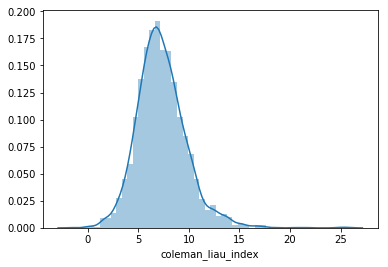

In [242]:
import seaborn as sns, numpy as np

_ = sns.distplot(df_Reviews['coleman_liau_index'])